In [5]:
import json
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from certainty_estimator.predict_certainty import CertaintyEstimator
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
data = []
with open('LIAR_test_explain_then_score_gpt-4-0125-preview_temp0.5_calibrated.jsonl', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

In [8]:
df['certainty'] = df['calibrated-uncertainty'].apply(lambda x: abs(0.5-x) * 2)

In [12]:
sentence_estimator = CertaintyEstimator(task='sentence-level', use_auth_token=False)
findings = [item['gpt-answer'] for item in data]
df['assertivity'] = [value / 6 for value in sentence_estimator.predict(findings, tqdm=tqdm)]

/Users/pnair/opt/anaconda3/envs/mac_stable/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/Users/pnair/opt/anaconda3/envs/mac_stable/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/pnair/opt/anaconda3/envs/mac_stable/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/Users/pnair/opt/anaconda3/envs/mac_stable/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
9it [01:08,  7.56s/it]                       


/var/folders/yg/j8ynkxts7_l7n_p9hqk0nd5m0000gp/T/ipykernel_54480/2347347096.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['certainty'], label='Certainty Distribution', kde=True, color='red')
/var/folders/yg/j8ynkxts7_l7n_p9hqk0nd5m0000gp/T/ipykernel_54480/2347347096.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457a

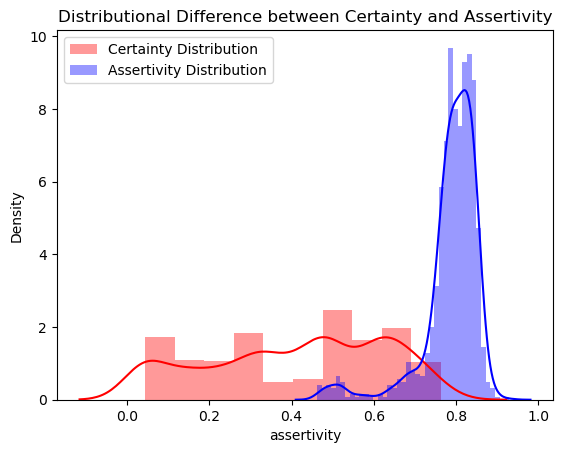

In [14]:
sns.distplot(df['certainty'], label='Certainty Distribution', kde=True, color='red')
sns.distplot(df['assertivity'], label='Assertivity Distribution', kde=True, color='blue')
plt.legend()
plt.title('Distributional Difference between Certainty and Assertivity')
plt.show()

In [28]:
df.columns

Index(['id', 'label', 'text', 'subject', 'speaker', 'job_title', 'state_info',
       'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_onfire_counts',
       'context', 'example_id', 'messages', 'temperature', 'model',
       'max_tokens', 'gpt-answer', 'gpt-message', 'prompt_tokens',
       'completion_tokens', 'gpt-score', 'gpt-prediction',
       'calibrated-uncertainty', 'certainty', 'assertivity'],
      dtype='object')

In [74]:
df['assertivity']

0       0.816930
1       0.828445
2       0.851153
3       0.859447
4       0.851960
          ...   
1092    0.831349
1093    0.791488
1094    0.484340
1095    0.811370
1096    0.502409
Name: assertivity, Length: 1097, dtype: float64

In [109]:
import json
import openai
import os
from sklearn.metrics import mean_absolute_error
import re
from sklearn.preprocessing import QuantileTransformer
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import torch
from openai import OpenAI

client = OpenAI(
    api_key='API_KEY')

CONTENT = \
"""
We will present you with a statement. Your task is to evaluate the linguistic assertivity of it. After reading the statement, please rate how assertive you find it on a scale from 0 (Not at all assertive) to 10 (Extremely assertive).

Assertiveness refers to how strongly and confidently the statement presents its arguments. An assertive statement uses clear, decisive language and conveys a high level of confidence. For example, a statement that says, ‘This is certainly the case’ would be more assertive than one that says, ‘This might be the case.’

Please be consistent in your ratings. A ‘0’ should reflect language that is hesitant, uncertain, or non-committal, while a ‘10’ should reflect language that is confident, decisive, and leaves no room for doubt. ONLY GIVE ME A FLOAT BETWEEN 0 and 10 AS YOUR RESPONSE PLEASE.
"""
# Example completion provided at the beginning
def get_completion(text):
    completion = client.chat.completions.create(
        model="ft:gpt-4o-2024-08-06:ps-project-research:scibert-comparison-finetuning:A9FxiM4R",
        messages=[
            {"role": "system", "content": CONTENT},
            {"role": "user", "content": text},
        ]
    )
    return completion

# Function to create a thread, read the question from scibert-finetuning/data/test_data.csv only the text attribute,
# get the response from the assistant, and add the response to a list after converting it into float
def get_responses(texts):
    # texts = df['text'].tolist()
    responses = []
    counter = 0
    for text in tqdm(texts):
        completion = get_completion(text)
        value = completion.choices[0].message.content.strip()
        try:
            responses.append(float(value))
        except:
            matches = re.findall(r"[-+]?\d*\.\d+|\d+", value)
            if matches:
                val = float(matches[0])
                # Clamp the value to be within 0.0 to 5.0
                # val = max(0.0, min(5.0, val))
            else:
                val = None
            responses.append(val)
        counter += 1
        # print(f"response {counter}: {value}")
    return responses

In [113]:
# Get the responses
responses = get_responses(df['text'].tolist())

responses = torch.tensor(responses, dtype=torch.float32)
mean_pred = torch.mean(responses)
std_pred = torch.std(responses)

min_pred = torch.min(responses)
max_pred = torch.max(responses)
# standardized_pred = (responses - mean_pred) / std_pred

standardized_pred = (responses - min_pred) / (max_pred - min_pred)

print(standardized_pred)

tensor([0.6970, 0.6170, 0.6350,  ..., 0.6641, 0.5018, 0.5864])


/var/folders/yg/j8ynkxts7_l7n_p9hqk0nd5m0000gp/T/ipykernel_54480/4290530411.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  responses = torch.tensor(responses, dtype=torch.float32)


/var/folders/yg/j8ynkxts7_l7n_p9hqk0nd5m0000gp/T/ipykernel_54480/2310092382.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['certainty'], label='Certainty Distribution', kde=True, color='red')
/var/folders/yg/j8ynkxts7_l7n_p9hqk0nd5m0000gp/T/ipykernel_54480/2310092382.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457a

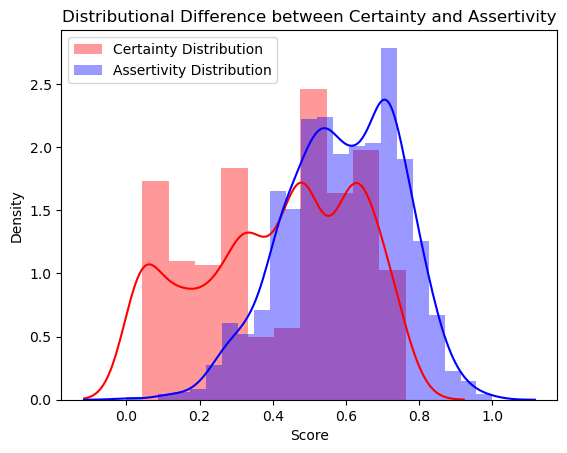

In [118]:
sns.distplot(df['certainty'], label='Certainty Distribution', kde=True, color='red')
sns.distplot(standardized_pred.numpy(), label='Assertivity Distribution', kde=True, color='blue')
# sns.distplot(df['assertivity'], label='Assert PEI', kde=True, color='green')
plt.legend()
plt.title('Distributional Difference between Certainty and Assertivity')
plt.xlabel("Score")
plt.show()


In [119]:
## ASSERTIVITY SCORES ON GPT EXPLANATIONS OF LABELS
# responses_gpt_exp = get_responses(df['gpt-answer'].tolist())

# responses_gpt_exp = torch.tensor(responses_gpt_exp, dtype=torch.float32)
# mean_pred_exp = torch.mean(responses_gpt_exp)
# std_pred_exp = torch.std(responses_gpt_exp)
# standardized_pred_exp = (responses_gpt_exp - mean_pred_exp) / std_pred_exp

# print(standardized_pred_exp)

### Use finetuned GPT for getting assertivity scores on the same data as the survey (250 statements)

In [123]:
survey_data_df = pd.read_csv("analysis/dta/llm_with_attention_checks.csv")

# Get the responses
responses_survey = get_responses(survey_data_df['text'].tolist())

responses_survey = torch.tensor(responses_survey, dtype=torch.float32)
mean_pred = torch.mean(responses_survey)
std_pred = torch.std(responses_survey)

min_pred = torch.min(responses_survey)
max_pred = torch.max(responses_survey)
# standardized_pred = (responses - mean_pred) / std_pred

standardized_pred_survey = (responses_survey - min_pred) / (max_pred - min_pred)
survey_data_df['ft_gpt_response'] = responses.tolist()
survey_data_df['ft_gpt_norm'] = standardized_pred_survey.tolist()
# print(standardized_pred)

In [124]:
survey_data_df.to_csv("../../analysis/dta/llm_with_attention_checks.csv")